In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [2]:
# Paso 1: Definición de parámetros modificables
num_features = 15                  # Número de variables predictoras a usar
test_size = 0.3                    # Tamaño del conjunto de prueba
random_state = 42                  # Semilla para reproducibilidad
max_iter = 5000                    # Iteraciones máximas para Logit
logit_threshold = 0.6              # Umbral de decisión para Logit
tree_max_depth = 4                 # Profundidad máxima para árbol


In [3]:
# Paso 2: Cargar y preparar los datos
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
X = X[data.feature_names[:num_features]]  # Seleccionar N primeras variables


In [4]:
# Paso 3: Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)


In [5]:
# Paso 4: Modelos
log_model = LogisticRegression(max_iter=max_iter)
log_model.fit(X_train, y_train)
y_proba_log = log_model.predict_proba(X_test)[:, 1]
y_pred_log = (y_proba_log >= logit_threshold).astype(int)

tree_model = DecisionTreeClassifier(random_state=random_state, max_depth=tree_max_depth)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
y_proba_tree = tree_model.predict_proba(X_test)[:, 1]


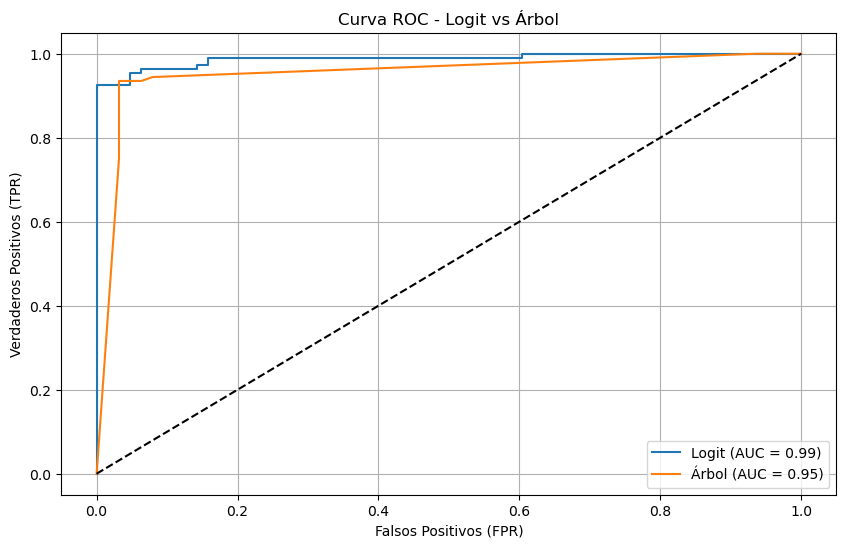

In [6]:
# Paso 5: Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f"Logit (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Árbol (AUC = {roc_auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Logit vs Árbol")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Paso 6: Reportes y matrices
conf_log = confusion_matrix(y_test, y_pred_log)
conf_tree = confusion_matrix(y_test, y_pred_tree)
report_log = classification_report(y_test, y_pred_log, output_dict=True)
report_tree = classification_report(y_test, y_pred_tree, output_dict=True)


In [8]:
# Paso 7: Crear comparativa
df_comp = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision clase 1", "Recall clase 1", "F1-score clase 1", "F1-score macro"],
    "Logit": [
        report_log["accuracy"],
        report_log["1"]["precision"],
        report_log["1"]["recall"],
        report_log["1"]["f1-score"],
        report_log["macro avg"]["f1-score"]
    ],
    "Árbol de Decisión": [
        report_tree["accuracy"],
        report_tree["1"]["precision"],
        report_tree["1"]["recall"],
        report_tree["1"]["f1-score"],
        report_tree["macro avg"]["f1-score"]
    ]
})


In [9]:
# Paso 8: Resultados fila a fila
df_resultados = X_test.copy()
df_resultados["Real"] = y_test.values
df_resultados["Logit_Pred"] = y_pred_log
df_resultados["Logit_Prob_benigno"] = y_proba_log
df_resultados["Arbol_Pred"] = y_pred_tree
df_resultados["Arbol_Prob_benigno"] = y_proba_tree
df_resultados["Diferencia_Modelos"] = df_resultados["Logit_Pred"] - df_resultados["Arbol_Pred"]


In [10]:
# Paso 9: Crear DataFrame de parámetros
df_parametros = pd.DataFrame({
    "Parámetro": [
        "Número de variables predictoras",
        "Porcentaje conjunto de prueba",
        "Semilla aleatoria (random_state)",
        "Iteraciones máx Logit (max_iter)",
        "Umbral de decisión Logit",
        "Profundidad máx árbol (max_depth)"
    ],
    "Valor": [
        num_features,
        test_size,
        random_state,
        max_iter,
        logit_threshold,
        tree_max_depth
    ]
})

print(df_parametros)

                           Parámetro   Valor
0    Número de variables predictoras    15.0
1      Porcentaje conjunto de prueba     0.3
2   Semilla aleatoria (random_state)    42.0
3   Iteraciones máx Logit (max_iter)  5000.0
4           Umbral de decisión Logit     0.6
5  Profundidad máx árbol (max_depth)     4.0


In [11]:
# Paso 10: Exportar a Excel con múltiples hojas
with pd.ExcelWriter("modelo_comparativo_logit_arbol.xlsx") as writer:
    df_resultados.to_excel(writer, sheet_name="Resultados Detallados", index=False)
    df_comp.to_excel(writer, sheet_name="Comparación Métricas", index=False)
    df_parametros.to_excel(writer, sheet_name="Parámetros", index=False)